## **Competition Description** 
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, we are challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. We will have access to a dataset of 10,000 tweets that were hand classified.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

Acknowledgments
This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website here.

Tweet source: https://twitter.com/AnyOtherAnnaK/status/629195955506708480

# **Brief description of the problem and data**

### **Importing necessary libraries**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re

### **Importing the dataset**

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


### **Data Overview**

The dataset has:
* **keyword**: Maybe this is what the user assigns as the keyword in the tweet, or some other algo (another ML) picks up a word which is closely related to disaster. And we have to use this info in addition to the tweet to predict if it's a disaster tweet or not
* **location**: Location of the tweet. (See the location mentioned in the tweet as well? -> correspondence?)
* **text**: This is the actual tweet, contains tweet specific words, emojis, symbols [@,#], short forms, urls etc. Requires a lot of cleaning.
* **target**: The actual target which we want to predict.
   * 1 = disaster
   * 0 = not disaster



In [3]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
('There are {} rows and {} columns in train'.format(df_train.shape[0], df_train.shape[1]))
print('There are {} rows and {} columns in train'.format(df_test.shape[0],df_test.shape[1]))

There are 3263 rows and 4 columns in train


# **Exploratory Data Analysis**

### **Disaster vs Non-disaster distribution**

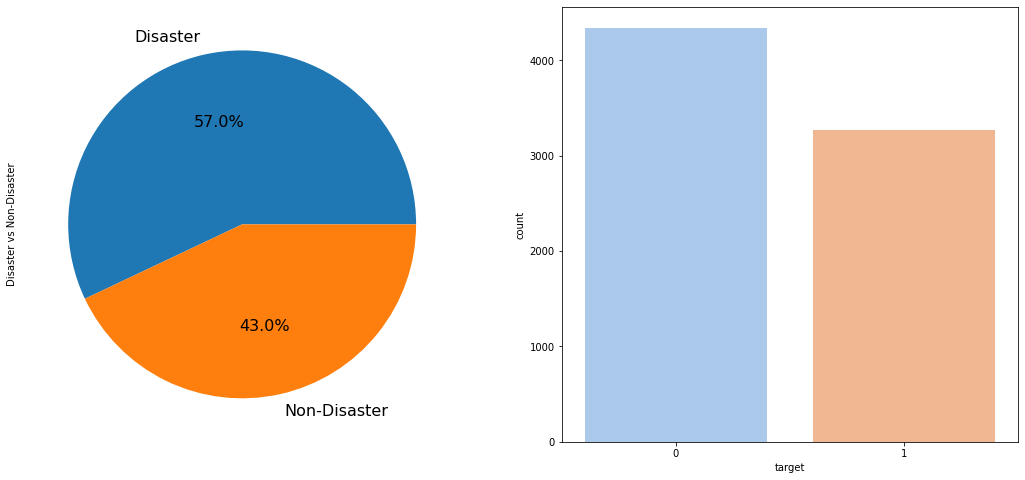

In [5]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
df_train.target.value_counts().plot(kind="pie",
                                           fontsize=16,
                                           labels=["Disaster", "Non-Disaster"],
                                           ylabel="Disaster vs Non-Disaster",
                                           autopct='%1.1f%%');

plt.subplot(1, 2, 2)
sns.countplot(x="target",data=df_train, palette="pastel")
plt.show()

### **Null values heat-map**

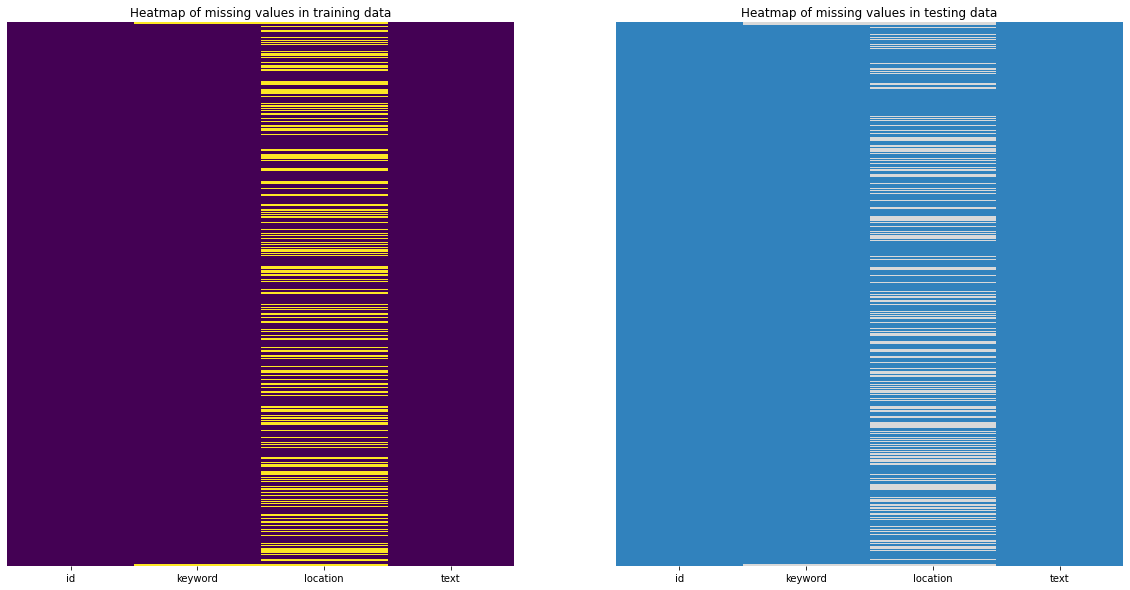

In [6]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20,10))
sns.heatmap(ax=axes[0], yticklabels=False, data=df_train.isnull(), cbar=False, cmap="viridis")
sns.heatmap(ax=axes[1], yticklabels=False, data=df_test.isnull(), cbar=False, cmap="tab20c")
axes[0].set_title('Heatmap of missing values in training data')
axes[1].set_title('Heatmap of missing values in testing data')
plt.show()

### **Word distribution**

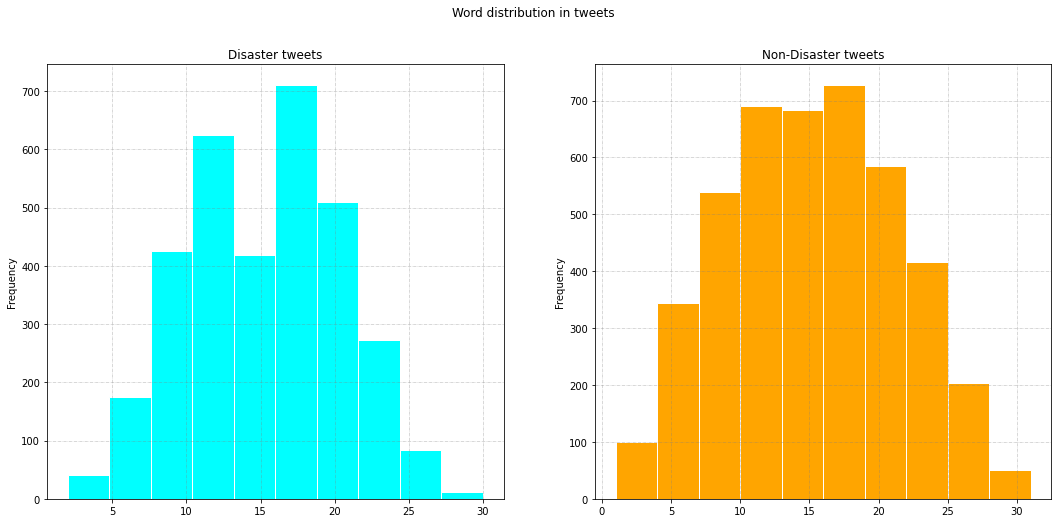

In [7]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
ax1 = df_train.query("target==1").text.map(lambda x: len(x.split())).plot(kind="hist",
                                                                    color="cyan",
                                                                    title="Disaster tweets",
                                                                    edgecolor='white');
plt.subplot(1, 2, 2)
ax2 = df_train.query("target==0").text.map(lambda x: len(x.split())).plot(kind="hist",
                                                                    color="orange",
                                                                    title="Non-Disaster tweets",
                                                                    edgecolor='white');

ax1.grid(visible = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.6)
ax2.grid(visible = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.6)
plt.suptitle('Word distribution in tweets')
plt.show()

### **Word cloud**



Word Cloud for Disaster Tweets




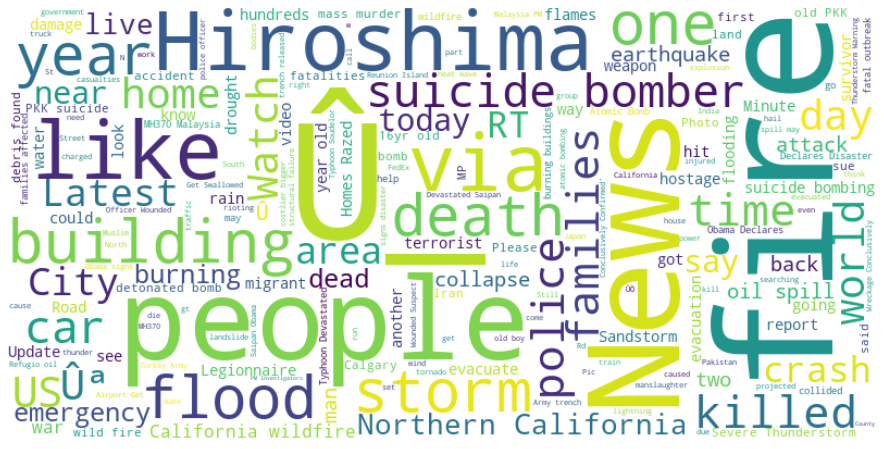



Word Cloud for Non-Disaster Tweets




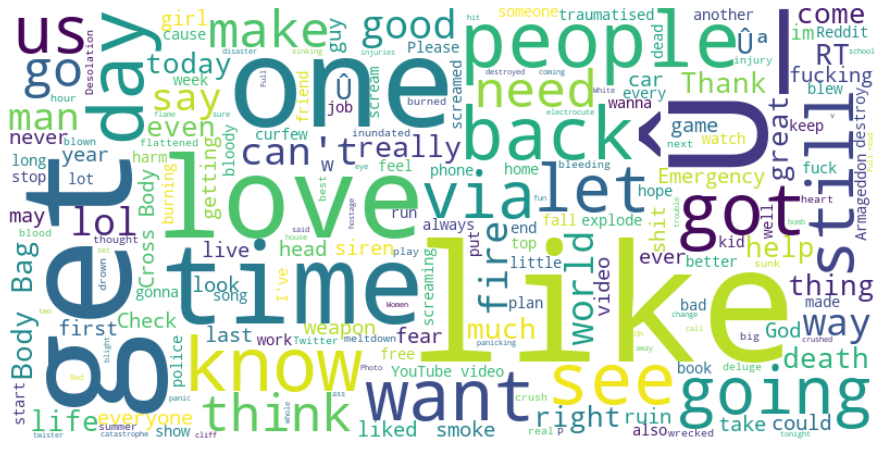

In [8]:
from nltk.corpus import stopwords
from wordcloud import WordCloud
stop_words= set(stopwords.words("english"))

stop_words.update(['https', 'http', 'amp', 'CO', 't', 'u', 'new', "I'm", "would"])

wc = WordCloud(width=800,
               height=400,
               max_words=200,
               stopwords=stop_words,
               background_color='white',
               max_font_size=150)
disaster_tweets_text = df_train.query("target==1").text
concat_disaster_tweets_text = disaster_tweets_text.str.cat(sep=" ")

non_disaster_tweets_text = df_train.query("target==0").text
concat_non_disaster_tweets_text = non_disaster_tweets_text.str.cat(sep=" ")

print('\n\nWord Cloud for Disaster Tweets\n\n')
wc.generate(concat_disaster_tweets_text)
plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

print('\n\nWord Cloud for Non-Disaster Tweets\n\n')
wc.generate(concat_non_disaster_tweets_text)
plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

#### We can observe that the disaster tweets have more extreme/violent words, while the non-disaster tweets have non-violent and unharmful words

## **Data Pre-processing**

In [9]:
# Helping function to remove unnecessary characters and special symbols
def cleanText(text):
    whitespace = re.compile(r"\s+")
    web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = web_address.sub('', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]", "", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    return text.lower()

#### **Removing unnecessary characters and special symbols**

In [10]:
df_train.text = [cleanText(item) for item in df_train.text]
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,the out of control wild fires in california ...,1
7610,10871,NaN,NaN,m km s of volcano hawaii httptcozdtoydebj,1
7611,10872,NaN,NaN,police investigating after an ebike collided w...,1


## **Split data into training and validation datasets**

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
test_sents = df_test['text'].to_numpy()
test_sents

array(['Just happened a terrible car crash',
       'Heard about #earthquake is different cities, stay safe everyone.',
       'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
       ..., 'Green Line derailment in Chicago http://t.co/UtbXLcBIuY',
       'MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3',
       '#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm'],
      dtype=object)

In [13]:
train_sents, val_sents, train_labels, val_labels = train_test_split(df_train['text'].to_numpy(), df_train['target'].to_numpy(),
                                                                    test_size=0.2, random_state=42)

print('Train:', len(train_sents))
print('Validation:', len(val_sents))
print('Test:', len(test_sents))

Train: 6090
Validation: 1523
Test: 3263


In [14]:
RAW_TEXT_DATA_STORE = dict(zip(['train', 'validation', 'test'], [train_sents, val_sents, test_sents]))
LABEL_DATA_STORE = {'train': train_labels[:, np.newaxis], 'validation': val_labels[:, np.newaxis]}

In [15]:
# View first 10 train tweets and their labels
train_sents[:10], train_labels[:10]

(array(['courageous and honest analysis of need to use atomic bomb in  hiroshima japanese military refused surrender ',
        '  wld b a shame if that golf cart became engulfed in flames boycottbears',
        'tell  to rescind medals of honor given to us soldiers at the massacre of wounded knee sign now amp rt ',
        'worried about how the ca drought might affect you extreme weather does it dampen our economy httptcofdzzumywi',
        ' lava blast amp power red pantherattack  ',
        'wreckage conclusively confirmed as from mh malaysia pm investigators and the families of those who were httptcoyixrhqgb',
        'our builder is having a dental emergency which has ruined my plan to emotionally blackmail him this afternoon with my bump',
        'bmx issues areal flood advisory for shelby  till aug   pm cdt httptcooddekvli',
        'wisenews  chinas stock market crash are there gems in the rubble httptcoaodftbmgu',
        ' getting hit by a foul ball while sitting there is h

## **Converting text to numbers**

Before we pass our text tweets to the machine learning algorithm, we somehow have to convert them into numbers i.e. encode the information contained in the text in a somewhat meaningful textual representation.

In NLP, there are two main concepts to convert text into numbers:

Tokenization - This is basically converting a peice of text into a sequence of tokens. Each token is assigned a unique index in the corpus vocabulary. There are three main levels of tokenization:
1. word-level tokenization: For a sentence, "I love data science", depending upon the tokenizer rules, this may be converted into \ {'I': 0, 'love': 1, 'data': 2, 'science': 3}. As we encounter more words, each will be assigned its unique index in the vocab.
2. character-level tokenization: In this each letter [A-Za-z]/symbol[special chars]/digit[0-9] depending on the vocabulary chosen is assigned an unique index. Every character in the sentence is considered a separate token.
3. sub-word tokenization: This is somewhat between word-level and character-level. It involves breaking individual words into smaller sub-parts and then assigning each sub-part its unique index in the vocabulary. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". These subwords are decided based on their frequency to minimize the number of subword tokens to create. Hence, each word could be composed of multiple tokens.

Embeddings - An embedding is the semantic meaning of a word/sentence/token encoded in a numerical representation. These are learned in an unsupervised way (mostly!) from large text corpus, through various ways
1. Embedding layer (your own custom embedding; learn from scratch or fine-tune existing) using tf.keras.layers.Embedding
2. Word2Vec: Continous BOW, Continous skip-gram (shallow NN)
3. GlOVe: Does not even use neural network
4. Fasttext
5. Bert embeddings
6. Many more...

We can get these pretrained embeddings by either downloading these off the internet, or directly from the Tensorflow Hub.

### **Text Vectorization (tokenization)**

To tokenize our words, we'll use the preprocessing layer tf.keras.layers.experimental.preprocessing.TextVectorization

The TextVectorization layer takes the follwing arguments:
* max_tokens: Maximum number of tokens I want to keep in my vocabulary (say 10000), includes a value for OOV token.
* standardize: Method for standardizing text. Default is lower_and_strip_punctuation which lowers text and removes all punctuation marks
* split - How to split text, default is whitespace
* ngrams - How many words to contain per token. If ngrams=2, then uptill two ngrams taken to tokenize a sentence. Each unique two-at-a-time
* output_mode - How to output tokens, can be int (integer mapping), binary - one-hot-encoding, count or tf-idf
* output_sequence_length - Limit maximum length of the output sequence to x tokens.
* pad_to_max_tokens - if True (default), pad shorter sequences with 0s (left or right)

In [16]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=10000,
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None,
                                    output_mode='int',
                                    output_sequence_length=None,
                                    pad_to_max_tokens=True)

text_vectorizer

2022-07-26 21:59:58.344571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 21:59:58.508418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 21:59:58.509462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 21:59:58.511526: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

(array([ 179.,  437.,  779., 1139., 1128., 1072.,  726.,  436.,  159.,
          35.]),
 array([ 0. ,  3.1,  6.2,  9.3, 12.4, 15.5, 18.6, 21.7, 24.8, 27.9, 31. ]),
 <BarContainer object of 10 artists>)

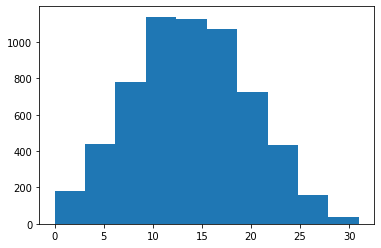

In [17]:
# Find average number of tokens (words) in training tweets
# Note: Somewhat wrong as this is not the actual complete tokenization procedure.
#       But roughly, this will be okayish.
token_lengths = [len(s.split()) for s in train_sents]
plt.hist(token_lengths)


In [18]:
np.percentile(token_lengths, 95)

24.0

Now we will create another text_vectorizer with custom options

In [19]:
MAX_VOCAB = 10000
MAX_SEQ_LENGTH = 24 # Cover 95% of the examples

text_vectorizer = TextVectorization(max_tokens=MAX_VOCAB,
                                    output_mode='int',
                                    output_sequence_length=MAX_SEQ_LENGTH)

To map our TextVectorizer instance text_vectorizer to our data, we call the .adapt() method (this is similar to .fit method of scikit-learn estimators)

In [20]:
text_vectorizer.adapt(train_sents)

2022-07-26 22:00:02.701673: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Now, our text_vectorizer has adapted to the training tweets. Let us try to tokenize a custom sentence

In [21]:
my_tweet = "It has been raining the whole day. My place is gonna flood so heavily!"
text_vectorizer([my_tweet])

<tf.Tensor: shape=(1, 24), dtype=int64, numpy=
array([[  16,   40,   59, 3088,    2,  353,   92,   13,  685,    9,  293,
         192,   29,    1,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]])>

The 0s at the end are the padding tokens since the tokenized sentence length is less than the max_tokens = 24

In [22]:
# Tokenize a random sentence
rand_sent = np.random.choice(train_sents)
print('Original Sentence:\n', rand_sent, '\n----\n')
print('Tokenized Sentence:\n', text_vectorizer([rand_sent]))

Original Sentence:
  im all for that to be honest if people want to go on a rampage let them use their own hands and feet no casualties 
----

Tokenized Sentence:
 tf.Tensor(
[[  34   41   10   15    5   21 4752   46   55  145    5  113   11    3
  7792  190   95  427  107  687 1659    8 1263   37]], shape=(1, 24), dtype=int64)



## **Create an embedding using an Embedding Layer**

The arguments of the Embedding layer tf.keras.layers.Embedding:
* input_dim - The size of the vocabulary
* output_dim - The size of the output embedding vector. How much information you want to encode (in case we want to learn)?
* embeddings_initializer - How to initialize the embedding matrix, default is uniform which randomly initializes embedding matrix with uniform distribution. This can also be any prelearned embedding
* input_length - Length of sequences being passed to the embedding layer

In [23]:
from tensorflow.keras import layers

EMBEDDING_DIM = 128

embedding_layer = layers.Embedding(input_dim=MAX_VOCAB, output_dim=EMBEDDING_DIM, 
                                   embeddings_initializer='uniform',
                                   input_length=MAX_SEQ_LENGTH)
embedding_layer

Let's try to convert a random sentence into a embeddings

In [24]:
rand_sent = np.random.choice(train_sents)
print('Original sentence:\n', rand_sent, '\n----\n')

sent_tokens = text_vectorizer([rand_sent])
print('Tokenized sentence:\n', sent_tokens, '\n----\n')

sent_embed = embedding_layer(text_vectorizer([rand_sent]))
print('Embedded sentence:\n', sent_embed)

Original sentence:
 theres a storm over cairo in the latest xmen apocalypse set photo  via  
----

Tokenized sentence:
 tf.Tensor(
[[ 279    3  102   60 5263    4    2  205 5651  351  264  319   51    0
     0    0    0    0    0    0    0    0    0    0]], shape=(1, 24), dtype=int64) 
----

Embedded sentence:
 tf.Tensor(
[[[-0.02418165  0.00519123 -0.0405416  ... -0.00675594  0.03943633
    0.03831523]
  [-0.0447206   0.04900963  0.01920173 ...  0.00965762  0.03118432
    0.00199369]
  [-0.02814412  0.004934   -0.04417372 ... -0.00747208 -0.0067093
    0.0203086 ]
  ...
  [-0.00088578  0.03416691 -0.03983281 ...  0.03936851  0.03953438
    0.01878137]
  [-0.00088578  0.03416691 -0.03983281 ...  0.03936851  0.03953438
    0.01878137]
  [-0.00088578  0.03416691 -0.03983281 ...  0.03936851  0.03953438
    0.01878137]]], shape=(1, 24, 128), dtype=float32)


### **Fitting Tokenizer on texts**

In [25]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.oov_token = '<oovToken>'
tokenizer.fit_on_texts(df_train.text)
vocab = tokenizer.word_index
vocabCount = len(vocab)+1
vocabCount

19198

In [26]:
x_Train = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(df_train.text.to_numpy()), padding='pre')
y_Train = df_train.target.to_numpy()

x_Train.shape, y_Train.shape

((7613, 31), (7613,))

# **Model Architecture**

In [27]:
MODELS = {}
PRED_FUNCS = {}
PREDICTIONS = {}

In [28]:
# from src.evaluate import KerasMetrics
# from src.visualize import plot_learning_curve
# Helper Functions
def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

def vis_training(h, start=1):
    epoch_range = range(start, len(h['loss'])+1)
    s = slice(start-1, None)

    plt.figure(figsize=[14,4])

    n = int(len(h.keys()) / 2)

    for i in range(n):
        k = list(h.keys())[i]
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, h[k][s], label='Training')
        plt.plot(epoch_range, h['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

### **Model: LSTM**

In [29]:
inputs = layers.Input(shape=(1,), dtype='string')
vec = text_vectorizer(inputs)
emb = embedding_layer(vec)
x = layers.LSTM(units=64)(emb)
outputs = layers.Dense(1, activation='sigmoid')(x)

lstm_model = tf.keras.models.Model(inputs, outputs, name='LSTM')
opt = tf.keras.optimizers.Adam(0.001)
lstm_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])
lstm_model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [30]:
h1 = lstm_model.fit(train_sents, train_labels, validation_data=(val_sents, val_labels),
          epochs=10, batch_size=32)
MODELS['LSTM'] = lstm_model

Epoch 1/10


2022-07-26 22:00:08.800439: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


191/191 [==============================] - 8s 13ms/step - loss: 0.5373 - accuracy: 0.7235 - auc: 0.7860 - val_loss: 0.4428 - val_accuracy: 0.8162 - val_auc: 0.8582
Epoch 2/10
191/191 [==============================] - 2s 9ms/step - loss: 0.3164 - accuracy: 0.8741 - auc: 0.9304 - val_loss: 0.4949 - val_accuracy: 0.7925 - val_auc: 0.8541
Epoch 3/10
191/191 [==============================] - 2s 9ms/step - loss: 0.2101 - accuracy: 0.9236 - auc: 0.9667 - val_loss: 0.5940 - val_accuracy: 0.7807 - val_auc: 0.8436
Epoch 4/10
191/191 [==============================] - 2s 9ms/step - loss: 0.1510 - accuracy: 0.9498 - auc: 0.9813 - val_loss: 0.6957 - val_accuracy: 0.7787 - val_auc: 0.8274
Epoch 5/10
191/191 [==============================] - 3s 15ms/step - loss: 0.1090 - accuracy: 0.9617 - auc: 0.9895 - val_loss: 0.9780 - val_accuracy: 0.7485 - val_auc: 0.8032
Epoch 6/10
191/191 [==============================] - 2s 9ms/step - loss: 0.0888 - accuracy: 0.9677 - auc: 0.9929 - val_loss: 1.0308 - val_

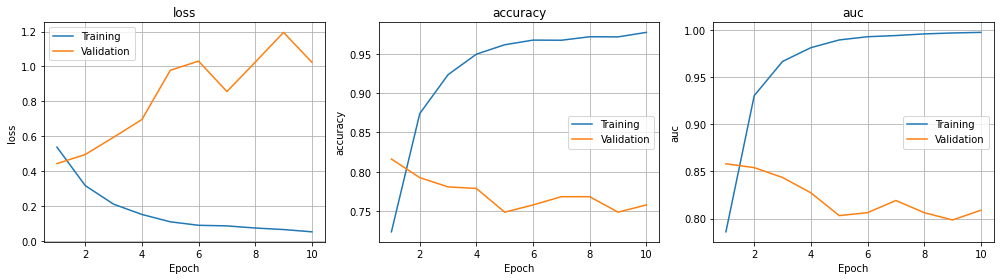

In [31]:
history1 = merge_history([h1])
vis_training(history1)

### **Model: GRU**

In [32]:
inputs = layers.Input(shape=(1,), dtype='string')
vec = text_vectorizer(inputs)
emb = embedding_layer(vec)
x = layers.GRU(units=64)(emb)
outputs = layers.Dense(1, activation='sigmoid')(x)

gru_model = tf.keras.models.Model(inputs, outputs, name='GRU')
opt = tf.keras.optimizers.Adam(0.001)
gru_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])
gru_model.summary()

Model: "GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [33]:
h2 = gru_model.fit(train_sents, train_labels, validation_data=(val_sents, val_labels),
          epochs=10, batch_size=32)
MODELS['GRU'] = gru_model

Epoch 1/10
191/191 [==============================] - 5s 14ms/step - loss: 0.2612 - accuracy: 0.8663 - auc_1: 0.9547 - val_loss: 0.6920 - val_accuracy: 0.7807 - val_auc_1: 0.8339
Epoch 2/10
191/191 [==============================] - 2s 9ms/step - loss: 0.0881 - accuracy: 0.9726 - auc_1: 0.9937 - val_loss: 0.9809 - val_accuracy: 0.7360 - val_auc_1: 0.8159
Epoch 3/10
191/191 [==============================] - 2s 9ms/step - loss: 0.0651 - accuracy: 0.9768 - auc_1: 0.9968 - val_loss: 1.0380 - val_accuracy: 0.7459 - val_auc_1: 0.8052
Epoch 4/10
191/191 [==============================] - 2s 9ms/step - loss: 0.0491 - accuracy: 0.9800 - auc_1: 0.9981 - val_loss: 1.0937 - val_accuracy: 0.7518 - val_auc_1: 0.7968
Epoch 5/10
191/191 [==============================] - 2s 10ms/step - loss: 0.0402 - accuracy: 0.9818 - auc_1: 0.9988 - val_loss: 1.2055 - val_accuracy: 0.7597 - val_auc_1: 0.7872
Epoch 6/10
191/191 [==============================] - 2s 9ms/step - loss: 0.0548 - accuracy: 0.9762 - auc_1:

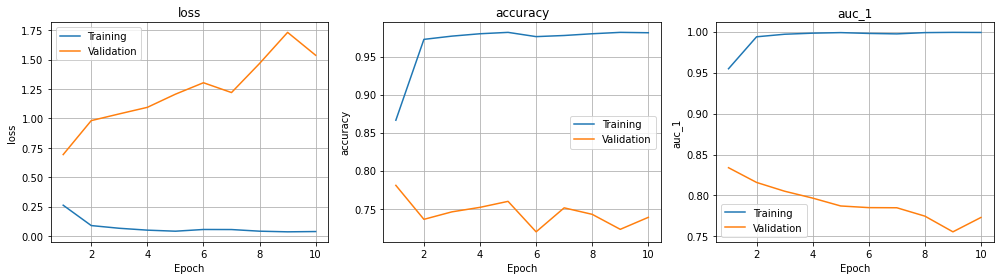

In [34]:
history2 = merge_history([h2])
vis_training(history2)

### **Model: Tensorflow Hub Pretrained Sentence Encoder**

* Rather than create a word level embedding, the Universal Sentence Encoder creates a sentence level embedding (hence the name)
* The embedding that we trained outputted a 128 dimensional vector for each word, where as the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.


The model that we are building follows from the concept of Encoder-Decoder architecture:
* Encoder is a model which takes the inputs and encodes it appropriately in a numeric representation, a Decoder takes that encoded information and decodes the desired output.
* Here the Universal Sentence Encoder encodes the information in the sentence in a 512 dimensional numerical representation. The architecture that proceeds from there will be our decoder part of the model.

In [35]:
import tensorflow_hub as tfhub

url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
embed_obj = tfhub.load(url)
sent = 'Omg there is a fire near my house!!!'
embed_sent = embed_obj([sent])

In [36]:
embed_sent.shape # 1 sentence passed => 512 dimensional embedding

TensorShape([1, 512])

In [37]:
embed_obj

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fb472fa6890>

Let us convert the embed_obj into a KerasLayer so that we can easily use it in our model

In [38]:
sent_encode_layer = tfhub.KerasLayer(embed_obj, input_shape=[],
                                     dtype=tf.string, trainable=False, name='USE')
use_model = tf.keras.models.Sequential([
    sent_encode_layer,
    layers.Dropout(0.5), # Avoiding overfitting due to most parameters in this layer
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name='USE-Simple-Dense')

opt = tf.keras.optimizers.Adam(0.001)
use_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])
use_model.summary()

Model: "USE-Simple-Dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [39]:
h3 = use_model.fit(train_sents, train_labels, validation_data=(val_sents, val_labels),
          epochs=10, batch_size=32)
MODELS['USE-Simple-Dense'] = use_model

Epoch 1/10
191/191 [==============================] - 8s 26ms/step - loss: 0.5478 - accuracy: 0.7662 - auc_2: 0.8178 - val_loss: 0.4366 - val_accuracy: 0.8063 - val_auc_2: 0.8778
Epoch 2/10
191/191 [==============================] - 3s 17ms/step - loss: 0.4564 - accuracy: 0.7918 - auc_2: 0.8597 - val_loss: 0.4160 - val_accuracy: 0.8129 - val_auc_2: 0.8830
Epoch 3/10
191/191 [==============================] - 3s 17ms/step - loss: 0.4433 - accuracy: 0.7997 - auc_2: 0.8667 - val_loss: 0.4108 - val_accuracy: 0.8188 - val_auc_2: 0.8857
Epoch 4/10
191/191 [==============================] - 4s 20ms/step - loss: 0.4323 - accuracy: 0.8064 - auc_2: 0.8736 - val_loss: 0.4110 - val_accuracy: 0.8155 - val_auc_2: 0.8850
Epoch 5/10
191/191 [==============================] - 4s 20ms/step - loss: 0.4297 - accuracy: 0.8071 - auc_2: 0.8748 - val_loss: 0.4066 - val_accuracy: 0.8148 - val_auc_2: 0.8865
Epoch 6/10
191/191 [==============================] - 3s 17ms/step - loss: 0.4262 - accuracy: 0.8064 - au

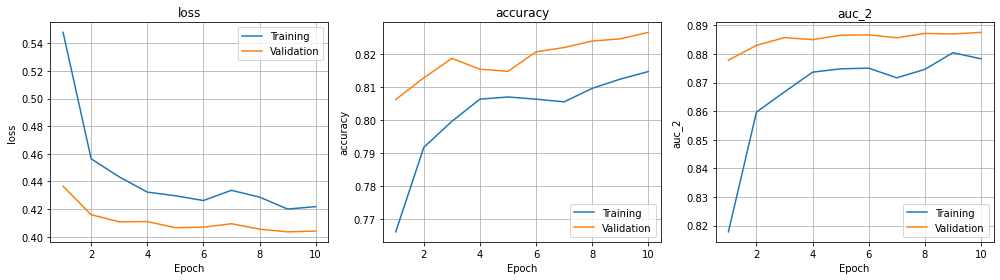

In [40]:
history3 = merge_history([h3])
vis_training(history3)

## **Conclussion**

A comparison of models LSTM, GRU, and TensorFlow Hub showed that TensorFlow Hub has the highest accuracy. The best learning rate was 0.001, which showed 81% accuracy.

## **Submission**

In [41]:
idCol = df_test['id'].to_numpy()
df_test = df_test.drop(columns=['keyword', 'location', 'id'])
df_test.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [42]:
df_test.text = [cleanText(item) for item in df_test.text]
df_test

,text
0,just happened a terrible car crash
1,heard about earthquake is different cities sta...
2,there is a forest fire at spot pond geese are ...
3,apocalypse lighting spokane wildfires
4,typhoon soudelor kills in china and taiwan
...,...
3258,earthquake safety los angeles ûò safety fasten...
3259,storm in ri worse than last hurricane my citya...
3260,green line derailment in chicago httptcoutbxlc...
3261,meg issues hazardous weather outlook hwo httpt...


In [43]:
xTest = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(df_test.text.to_numpy()), padding='pre', maxlen=31)

xTest.shape

(3263, 31)

In [44]:
xTest

array([[    0,     0,     0, ...,  1846,   118,    86],
       [    0,     0,     0, ...,   594,  1939,   219],
       [    0,     0,     0, ...,   321,    90,    40],
       ...,
       [    0,     0,     0, ...,     4,  1239,     1],
       [    0,     0,     0, ...,  1654,  1823, 13701],
       [    0,     0,     0, ...,    72,   250,  5877]], dtype=int32)

In [45]:
preds = use_model.predict(df_test)

In [46]:
preds = preds.reshape(len(preds))
for i in range(len(preds)):
    if preds[i]>0.5:
        preds[i] = 1
    else:
        preds[i] = 0

submission = pd.DataFrame({'id': idCol, 'target': preds})
submission.target = submission.target.astype(int)
submission.set_index('id')

,target
id,
0,1
2,1
3,1
9,1
11,1
...,...
10861,1
10865,1
10868,1


In [47]:
submission.to_csv('submission_use.csv', index=False)
print('Submission succesful!')

Submission succesful!


## **References**

1. [Notebook](https://www.kaggle.com/code/rakeshku1993/eda-preprocessing-emedding-model)

2. [Playlist](https://youtube.com/playlist?list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S)

3. [Basics in Tensorflow Disaster Tweets](https://abhi8893.github.io/tensorflow-deep-learning-mrdbourke/08-NLP-Basics-in-Tensorflow-Disaster-Tweets/)